<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

# DataDreamer Tutorial: Generating a dataset for instance segmentation, training a model, and deploying it to the OAK (optional)

In [ ]:
!pip install -q datadreamer

## Generate a dataset with your own classes (might take some time to download all models)

Make sure you are using the GPU runtime type (in Google Colab).

~4 min to generate 30 images

~43 secs to annotate them

In [ ]:
!datadreamer --save_dir generated_dataset \
             --class_names tractor horse bear \
             --prompts_number 30 \
             --prompt_generator simple \
             --num_objects_range 1 1 \
             --image_generator sdxl-turbo \
             --task instance-segmentation \
             --disable_lm_filter \
             --annotator_size base \
             --use_tta \
             --image_annotator owlv2-slimsam \
             --conf_threshold 0.2 \
             --seed 42

### Parameters
- `--save_dir` (required): Path to the directory for saving generated images and annotations.
- `--class_names` (required): Space-separated list of object names for image generation and annotation. Example: `person moon robot`.
- `--prompts_number` (optional): Number of prompts to generate for each object. Defaults to `10`.
- `--annotate_only` (optional): Only annotate the images without generating new ones, prompt and image generator will be skipped. Defaults to `False`.
- `--task`: Choose between detection, classification and instance segmentation. Default is `detection`.
- `--dataset_format`: Format of the dataset. Defaults to `raw`. Supported values: `raw`, `yolo`, `coco`, `luxonis-dataset`, `cls-single`.
- `--split_ratios`: Split ratios for train, validation, and test sets. Defaults to `[0.8, 0.1, 0.1]`.
- `--num_objects_range`: Range of objects in a prompt. Default is 1 to 3.
- `--prompt_generator`: Choose between `simple`, `lm` (Mistral-7B), `tiny` (tiny LM), and `qwen2` (Qwen2.5 LM). Default is `qwen2`.
- `--image_generator`: Choose image generator, e.g., `sdxl`, `sdxl-turbo` or `sdxl-lightning`. Default is `sdxl-turbo`.
- `--image_annotator`: Specify the image annotator, like `owlv2` for object detection or `clip` for image classification or `owlv2-slimsam` for instance segmentation. Default is `owlv2`.
- `--conf_threshold`: Confidence threshold for annotation. Default is `0.15`.
- `--annotation_iou_threshold`: Intersection over Union (IoU) threshold for annotation. Default is `0.2`.
- `--prompt_prefix`: Prefix to add to every image generation prompt. Default is `""`.
- `--prompt_suffix`: Suffix to add to every image generation prompt, e.g., for adding details like resolution. Default is `", hd, 8k, highly detailed"`.
- `--negative_prompt`: Negative prompts to guide the generation away from certain features. Default is `"cartoon, blue skin, painting, scrispture, golden, illustration, worst quality, low quality, normal quality:2, unrealistic dream, low resolution,  static, sd character, low quality, low resolution, greyscale, monochrome, nose, cropped, lowres, jpeg artifacts, deformed iris, deformed pupils, bad eyes, semi-realistic worst quality, bad lips, deformed mouth, deformed face, deformed fingers, bad anatomy"`.
- `--use_tta`: Toggle test time augmentation for object detection. Default is `False`.
- `--synonym_generator`: Enhance class names with synonyms. Default is `none`. Other options are `llm`, `wordnet`.
- `--use_image_tester`: Use image tester for image generation. Default is `False`.
- `--image_tester_patience`: Patience level for image tester. Default is `1`.
- `--lm_quantization`: Quantization to use for Mistral language model. Choose between `none` and `4bit`. Default is `none`.
- `--annotator_size`: Size of the annotator model to use. Choose between `base` and `large`. Default is `base`.
- `--disable_lm_filter`: Use only a bad word list for profanity filtering. Default is `False`.
- `--keep_unlabeled_images`: Whether to keep images without any annotations. Default if `False`.
- `--batch_size_prompt`: Batch size for prompt generation. Default is 64.
- `--batch_size_annotation`: Batch size for annotation. Default is `1`.
- `--batch_size_image`: Batch size for image generation. Default is `1`.
- `--device`: Choose between `cuda` and `cpu`. Default is `cuda`.
- `--seed`: Set a random seed for image and prompt generation. Default is `42`.
- `--config`: A path to an optional `.yaml` config file specifying the pipeline's arguments.


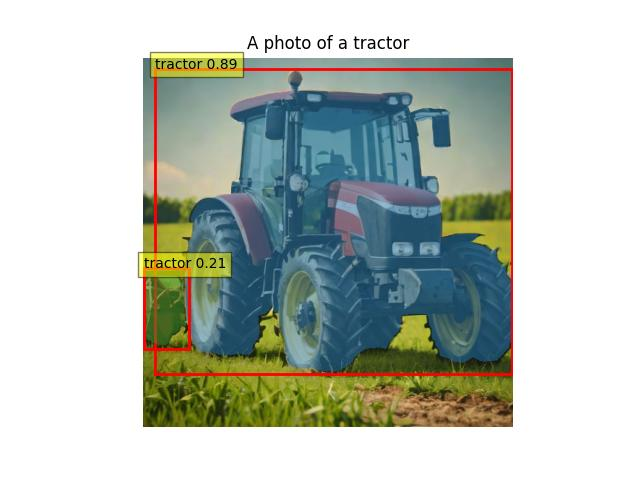

In [3]:
import os
from IPython.display import Image

Image(filename=os.path.join("generated_dataset/bboxes_visualization", "bbox_5.jpg"))

## Convert the dataset to YOLO format

In [4]:
from datadreamer.utils.convert_dataset import convert_dataset

In [5]:
convert_dataset(
    input_dir="generated_dataset",
    output_dir="generated_dataset_yolo",
    dataset_format="yolo",
    split_ratios=[0.8, 0.1, 0.1],
    copy_files=True,
    is_instance_segmentation=True,
)

In [6]:
!ls generated_dataset_yolo

data.yaml  test  train	val


# Train your model (YOLOv8 as an example)

In [ ]:
!pip install -q ultralytics

In [8]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")  # load a pretrained model

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.74M/6.74M [00:00<00:00, 110MB/s]


In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'

results = model.train(data="generated_dataset_yolo/data.yaml", epochs=200)

## Show the predictions

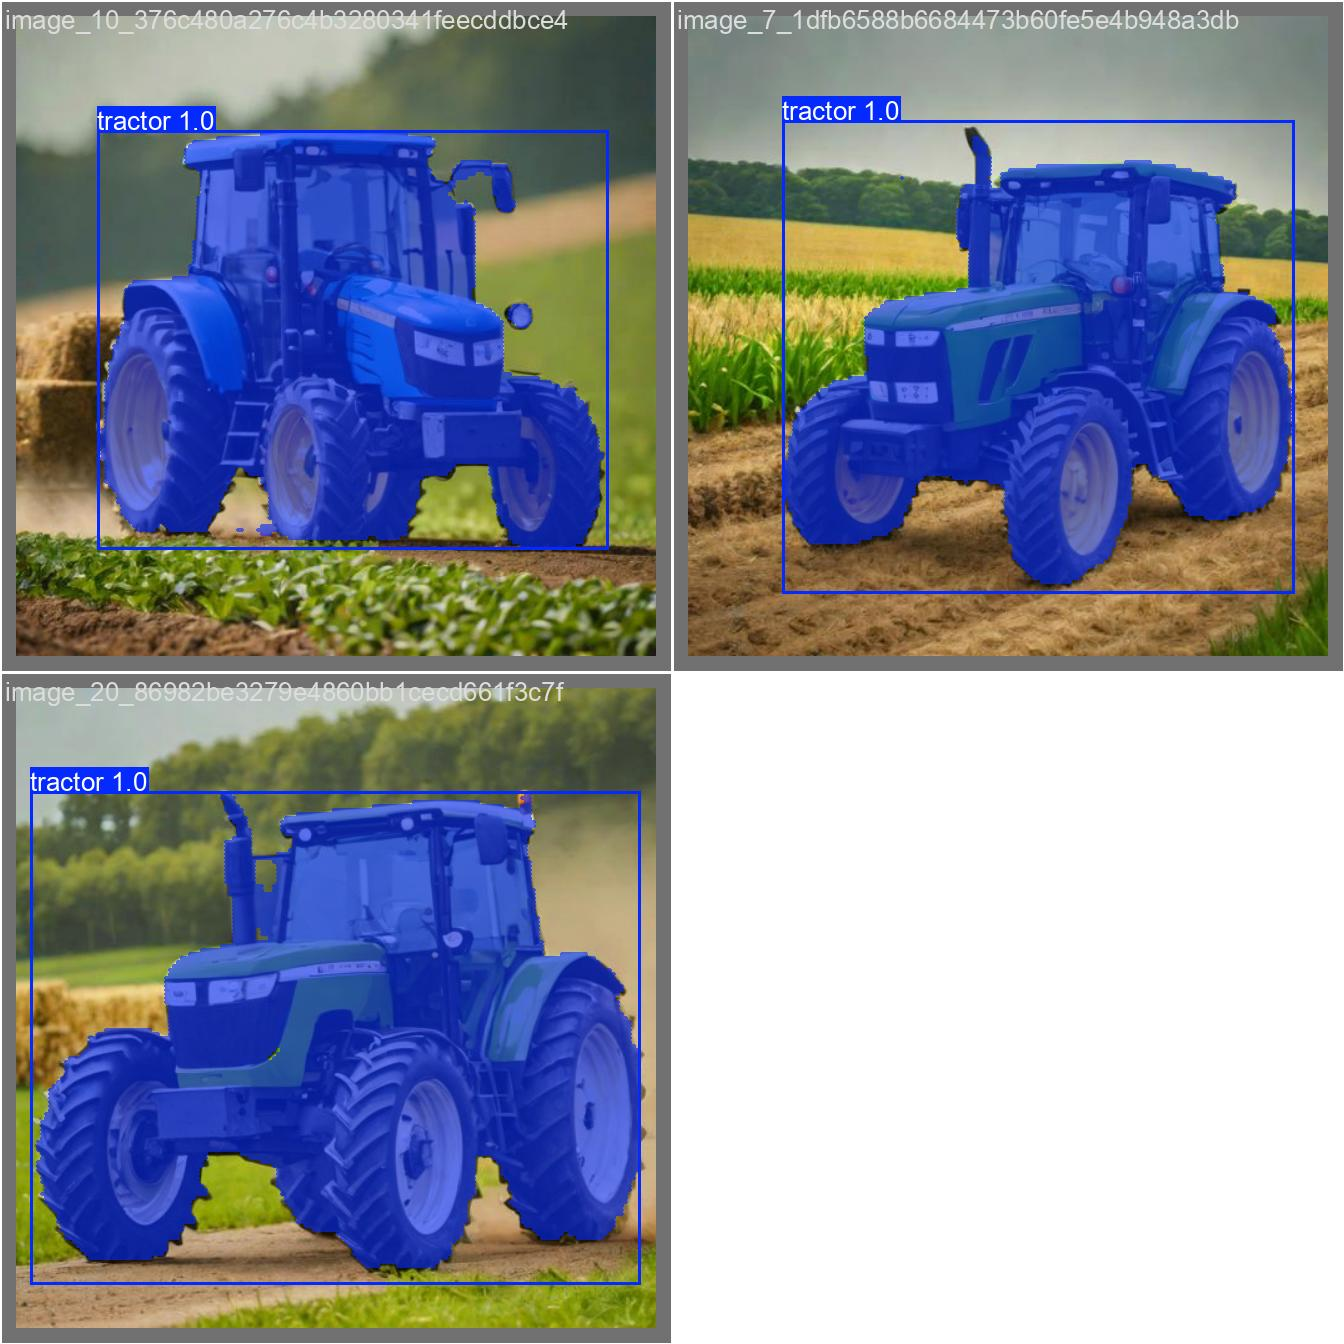

In [10]:
Image(filename=os.path.join(results.save_dir, "val_batch0_pred.jpg"))

In [11]:
metrics = model.val()

Ultralytics 8.3.21 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,649 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /content/generated_dataset_yolo/val/labels.cache... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


                   all          3          3      0.987          1      0.995      0.995      0.987          1      0.995      0.995
               tractor          3          3      0.987          1      0.995      0.995      0.987          1      0.995      0.995
Speed: 1.1ms preprocess, 42.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/segment/train2
